Author: Daniel Lusk, University of Potsdam

Inspired by: Ankit Kariryaa ([github repo](https://github.com/ankitkariryaa/An-unexpectedly-large-count-of-trees-in-the-western-Sahara-and-Sahel))

In [28]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from config import ModelComparison
from core.dataset_generator import DataGenerator
from core.utils import get_frames, unpatch_to_tile, get_biou, get_trees
from tensorflow.keras.metrics import BinaryIoU
from tqdm.notebook import tqdm


plt.style.use("lusk")

RUN_PREDICTIONS = False
NOTEBOOK = True

if NOTEBOOK:
    # Magic commands
    %matplotlib inline
    %reload_ext autoreload
    %autoreload 2

Load the configuration and get the image directories and model filenames.

In [2]:
config = ModelComparison.Config()
im_dirs = glob.glob(config.image_dir)
model_fns = glob.glob("./saved_models/UNet/*.h5")

Read all of the images (AKA frames) into memory and get test data

In [5]:
frames = get_frames(im_dirs, config)

# We can use all frames since they only consist of the test images
predict_idx = list(range(0, len(frames), 1))

annotation_channels = config.input_label_channel + config.input_weight_channel

X, y = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    predict_idx,
    frames,
    annotation_channels,
).all_sequential_patches(config.step_size)

  0%|          | 0/36 [00:00<?, ?it/s]

/Users/lusk/miniconda3/envs/rsiv/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/36 [00:00<?, ?it/s]

Load the model and perform predictions

In [63]:
# Load model after training
# If you load a model with different python version, then you may run into a
# problem: https://github.com/keras-team/keras/issues/9595#issue-303471777

frame_shape = (512, 512, 1)
tile_shape = (512 * 4, 512 * 9, 1)
stats = []
tiles_pred = []

y_true_tile = unpatch_to_tile(
    y[..., [0]],
    frame_shape,
    tile_shape,
)

if RUN_PREDICTIONS:
    for fn in tqdm(model_fns):
        print("Model:", os.path.basename(fn))
        model = tf.keras.models.load_model(
            fn,
            custom_objects={
                "tversky": config.loss,
                "dice_coef": config.metrics[0],
                "dice_loss": config.metrics[1],
                "accuracy": config.metrics[4],
                "specificity": config.metrics[2],
                "sensitivity": config.metrics[3],
            },
            compile=False,
        )

        # In case you want to use multiple GPU you can uncomment the following lines.
        # from tensorflow.python.keras.utils import multi_gpu_model
        # model = multi_gpu_model(model, gpus=2, cpu_merge=False)

        model.compile(
            optimizer=config.optimizer,
            loss=config.loss,
            metrics=config.metrics,
        )

        y_pred = model.predict(X, steps=1)

        # Restictch the predictions and labels
        # First we need to unpatchify the patches into their original frame shapes
        y_pred_tile = unpatch_to_tile(
            y_pred,
            frame_shape,
            tile_shape,
        )

        res = get_biou(y_pred_tile, y_true_tile)
        print("bIoU:", res)
        stats.append(res)
        tiles_pred.append(y_pred_tile)

    np.save("./tiles_pred.npy", np.array(tiles_pred))
    np.save("./biou_stats.npy", np.array(stats))
else:
    biou_stats = np.load("./biou_stats.npy")
    tiles_pred = np.load("./tiles_pred.npy")

Get bIoU of predictions and eroded labels and add stats to a dataframe

In [33]:
y_tile_true_eroded = rio.open("../../data/dap05/hand/label/393_5823_label_eroded_2020.tif").read()
y_tile_true_eroded = np.moveaxis(y_tile_true_eroded, 0, -1)
y_tile_true_eroded = np.where(y_tile_true_eroded >= 1, 1, 0)

/Users/lusk/miniconda3/envs/rsiv/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Get tree count of original labels

In [61]:
from skimage.measure import label, regionprops

y_tile_true = rio.open("../../data/dap05/hand/label/393_5823_label_2020.tif").read()
y_tile_true = np.moveaxis(y_tile_true, 0, -1)

labels = label(np.squeeze(y_tile_true)) # Ensure label count == region count
regions = regionprops(labels)  # Get regions with props
true_tree_ct = len(regions)

/Users/lusk/miniconda3/envs/rsiv/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [67]:
stats_df = pd.DataFrame(columns=["model", "labels_trained", "non-eroded biou", "eroded biou", "dilated biou", "tree count", "tree count pct"])

for i, (model_fn, stat, y_pred) in enumerate(zip(model_fns, biou_stats, tiles_pred)):
    model_name = os.path.splitext(os.path.basename(model_fn))[0]
    labels_trained = "eroded" if "eroded" in model_name else "non-eroded"
    uneroded_biou = stat
    eroded_biou = get_biou(y_pred, y_tile_true_eroded)
    trees = get_trees(y_pred)
    trees = label(trees)
    trees = regionprops(trees)
    tree_count = len(trees) - 1
    tree_ct_pct = tree_count / true_tree_ct
    stats_df.loc[i] = [model_name, labels_trained, uneroded_biou, eroded_biou, np.nan, tree_count, tree_ct_pct]

In [68]:
stats_df

model  ... tree count pct
0  20230201-1335_AdaDelta_weightmap_tversky_01234...  ...       2.129925
1  20230202-1814_AdaDelta_weightmap_tversky_obj1-...  ...       3.055323
2  20230203-1013_AdaDelta_eroded_weightmap_tversk...  ...       2.785415
3  20230203-1400_AdaDelta_weightmap_tversky_borde...  ...       4.315172
4  20230204-0936_AdaDelta_weightmap_tversky_erode...  ...       2.948030
5  20230204-1217_AdaDelta_weightmap_tversky_no-we...  ...       3.052808
6  20230204-1515_AdaDelta_weightmap_tversky_erode...  ...       3.190277

[7 rows x 7 columns]

Isolate trees by generating distmaps and performing watershed

In [30]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background

len(np.unique(labels)) - 1

2542

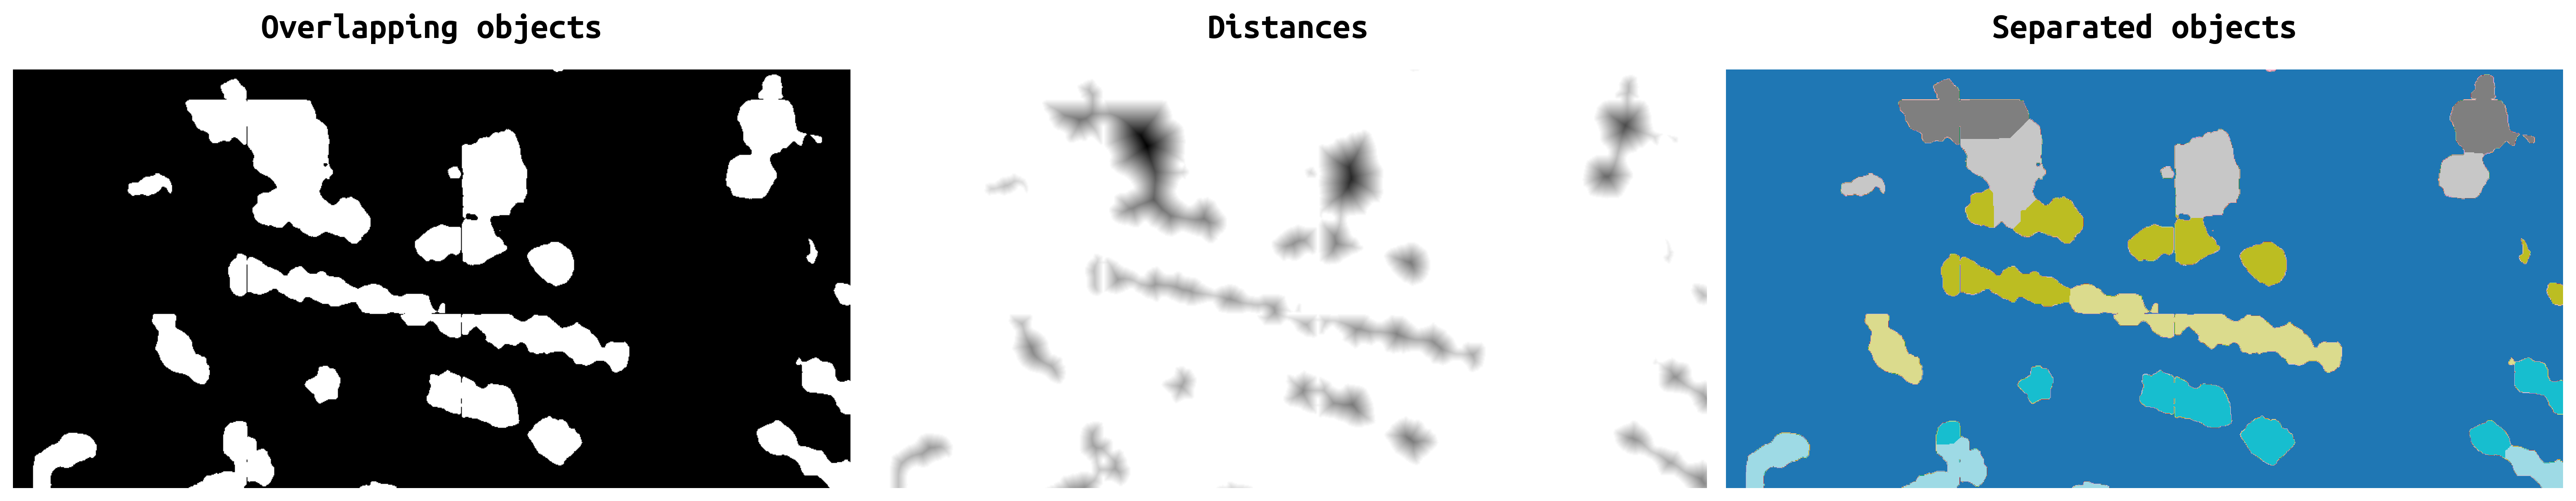

In [27]:

fig, axes = plt.subplots(ncols=3, figsize=(20, 11), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(y_pred[1500:2000, 1000:2000], cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance[1500:2000, 1000:2000], cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels[1500:2000, 1000:2000], cmap=plt.cm.tab20)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

Save the predictions as standalone images (WIP)

In [146]:
data_dir = "../../data/dap05"
tile_true = rio.open(os.path.join(data_dir, "hand/label/393_5823_label_2020.tif"))

### NOT DONE!
#####################
# for pred, fn in tqdm(zip(tiles_pred, model_fns)):
#     write_fn = f"{os.path.basename(fn).split('.')[0]}_pred.tif"
#     with rio.open('example.tif', 'w', **tile_true.profile) as dst:
#         dst.write(array.astype(rio.uint8), 1)

/Users/lusk/miniconda3/envs/rsiv/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'driver': 'GTiff', 'dtype': 'int64', 'nodata': None, 'width': 4608, 'height': 2048, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

Visualize the predictions

In [15]:
tile_true = rio.open("../../data/dap05/hand/label/393_5823_label_2020.tif").read()
tile_true = np.moveaxis(tile_true, 0, -1)
tile_true = np.where(tile_true >= 1, 1, 0)

/Users/lusk/miniconda3/envs/rsiv/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
len(tiles_pred)

7

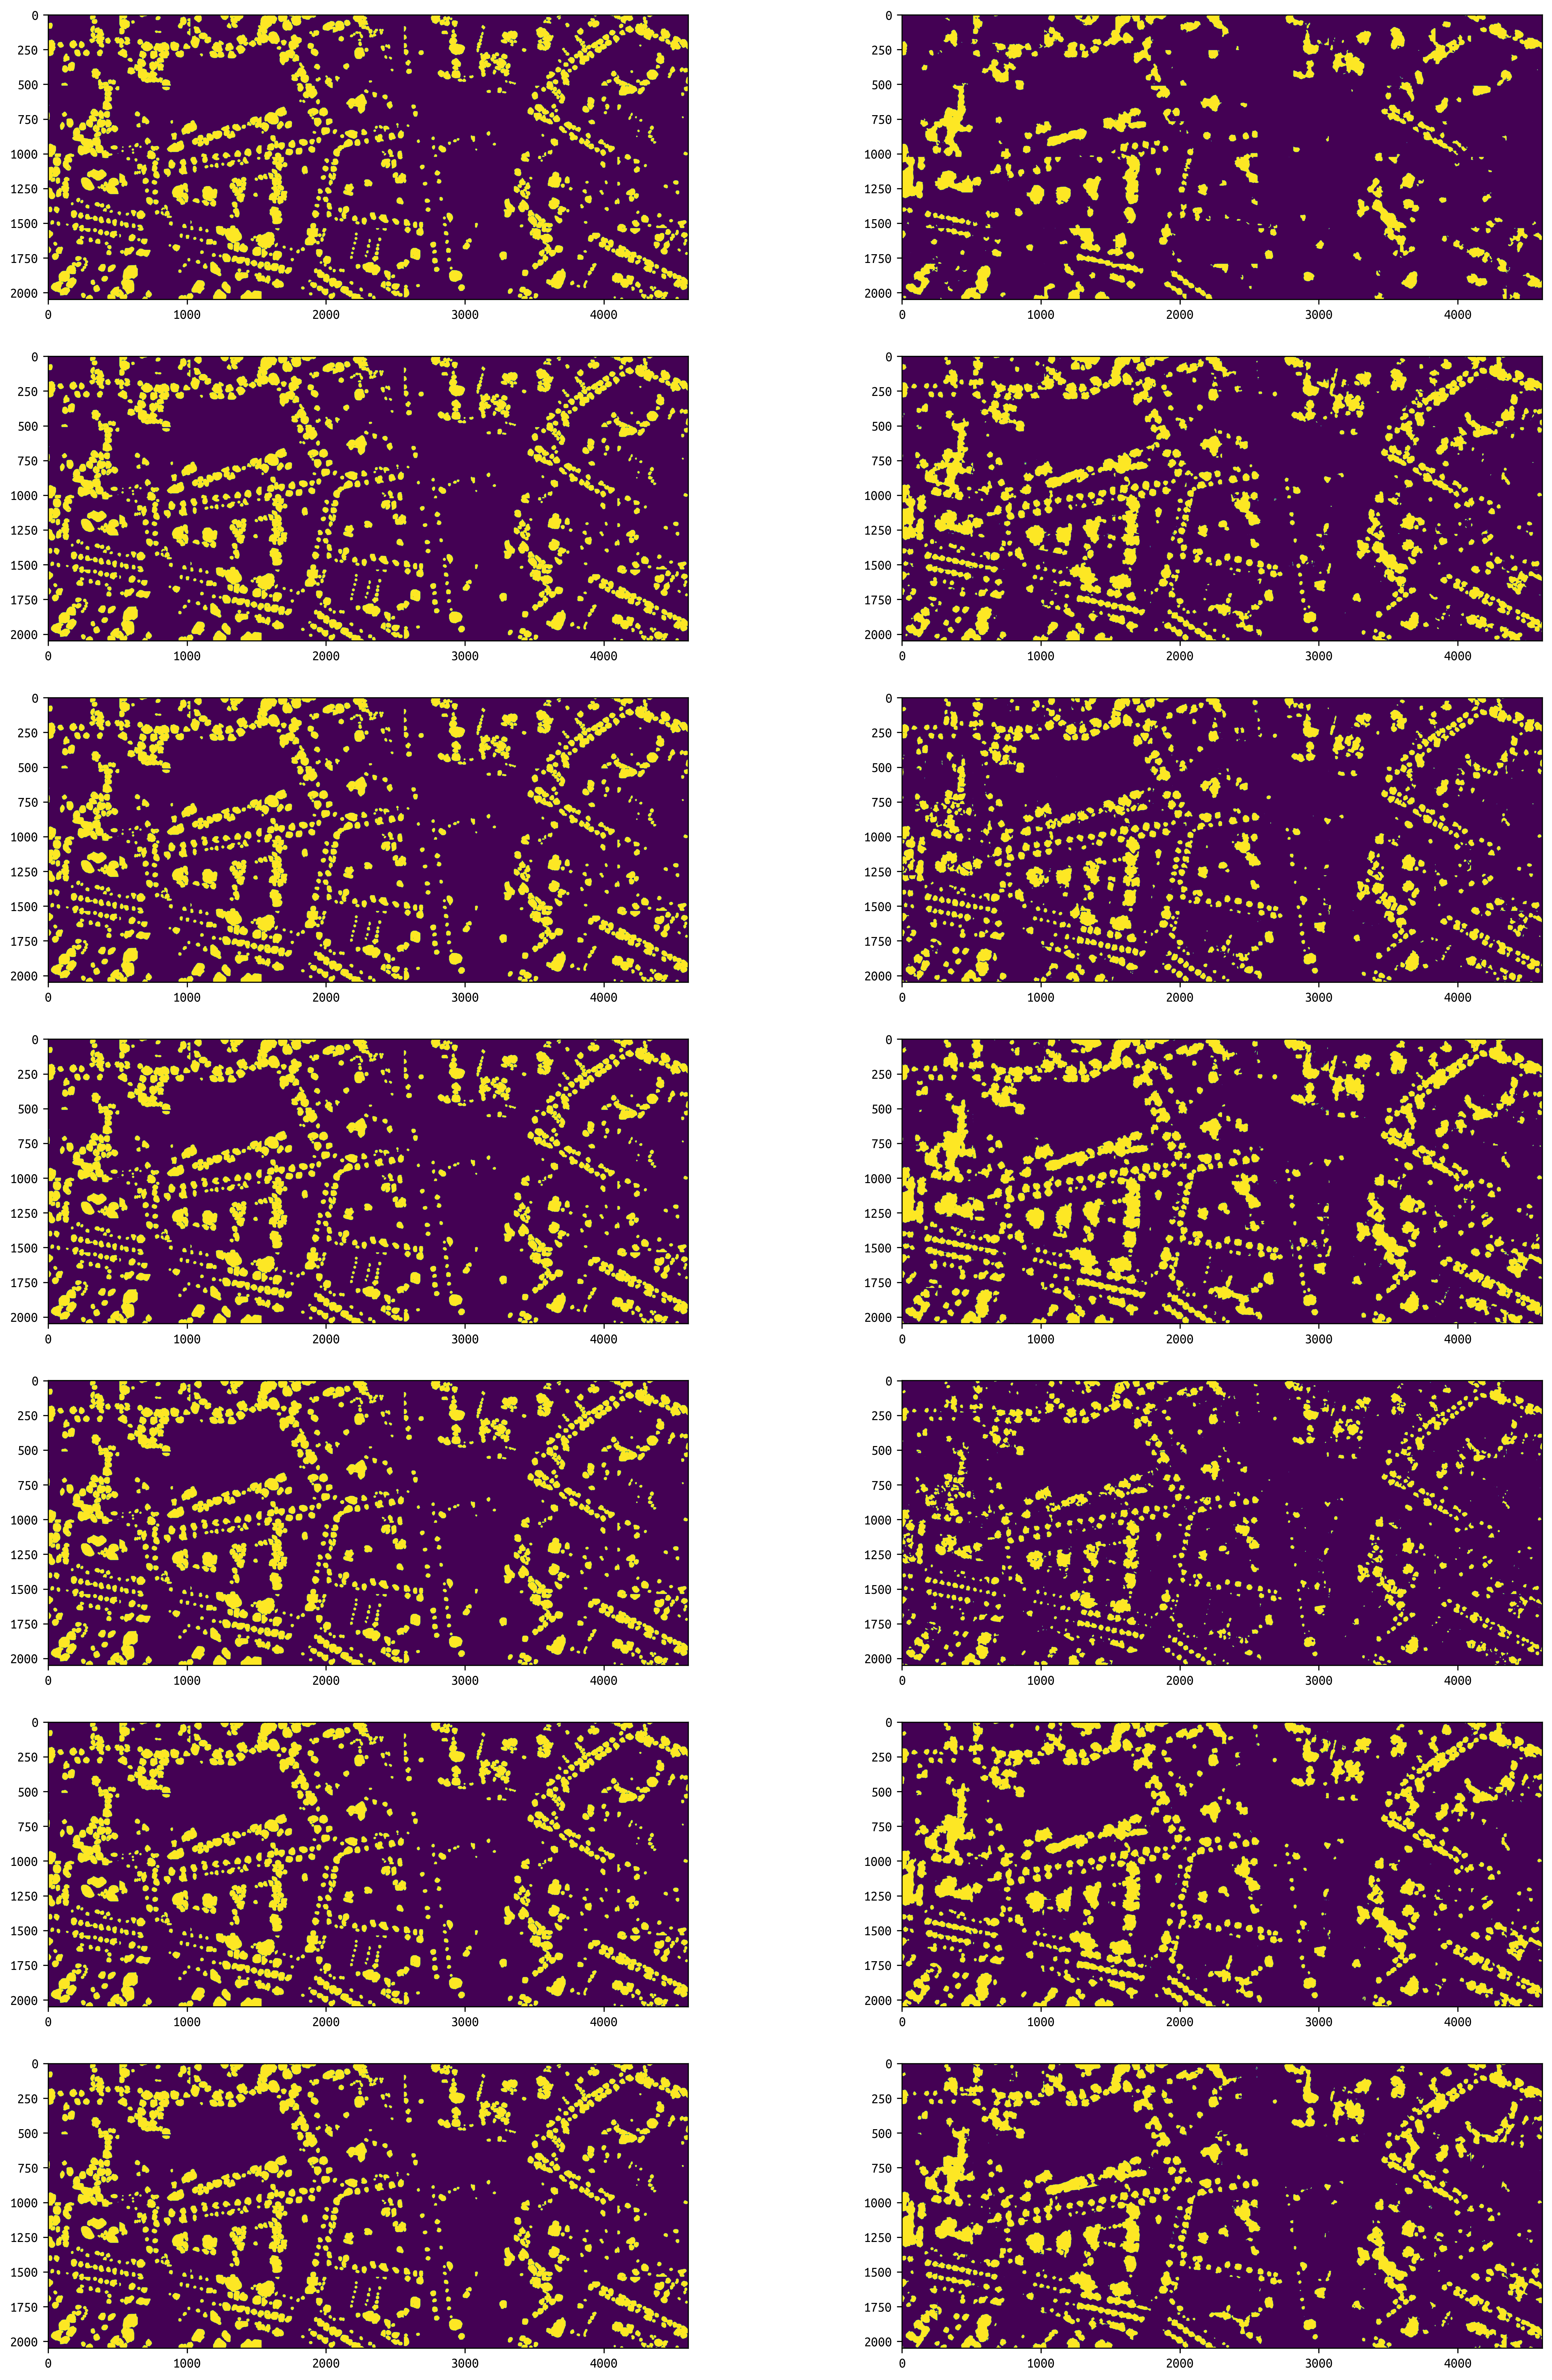

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(tiles_pred), 2, figsize=(20, 30))

for i, tile in enumerate(tiles_pred):
    ax[i][0].imshow(y_true_tile)
    ax[i][1].imshow(tile)

Fix the incorrect unpatchifying

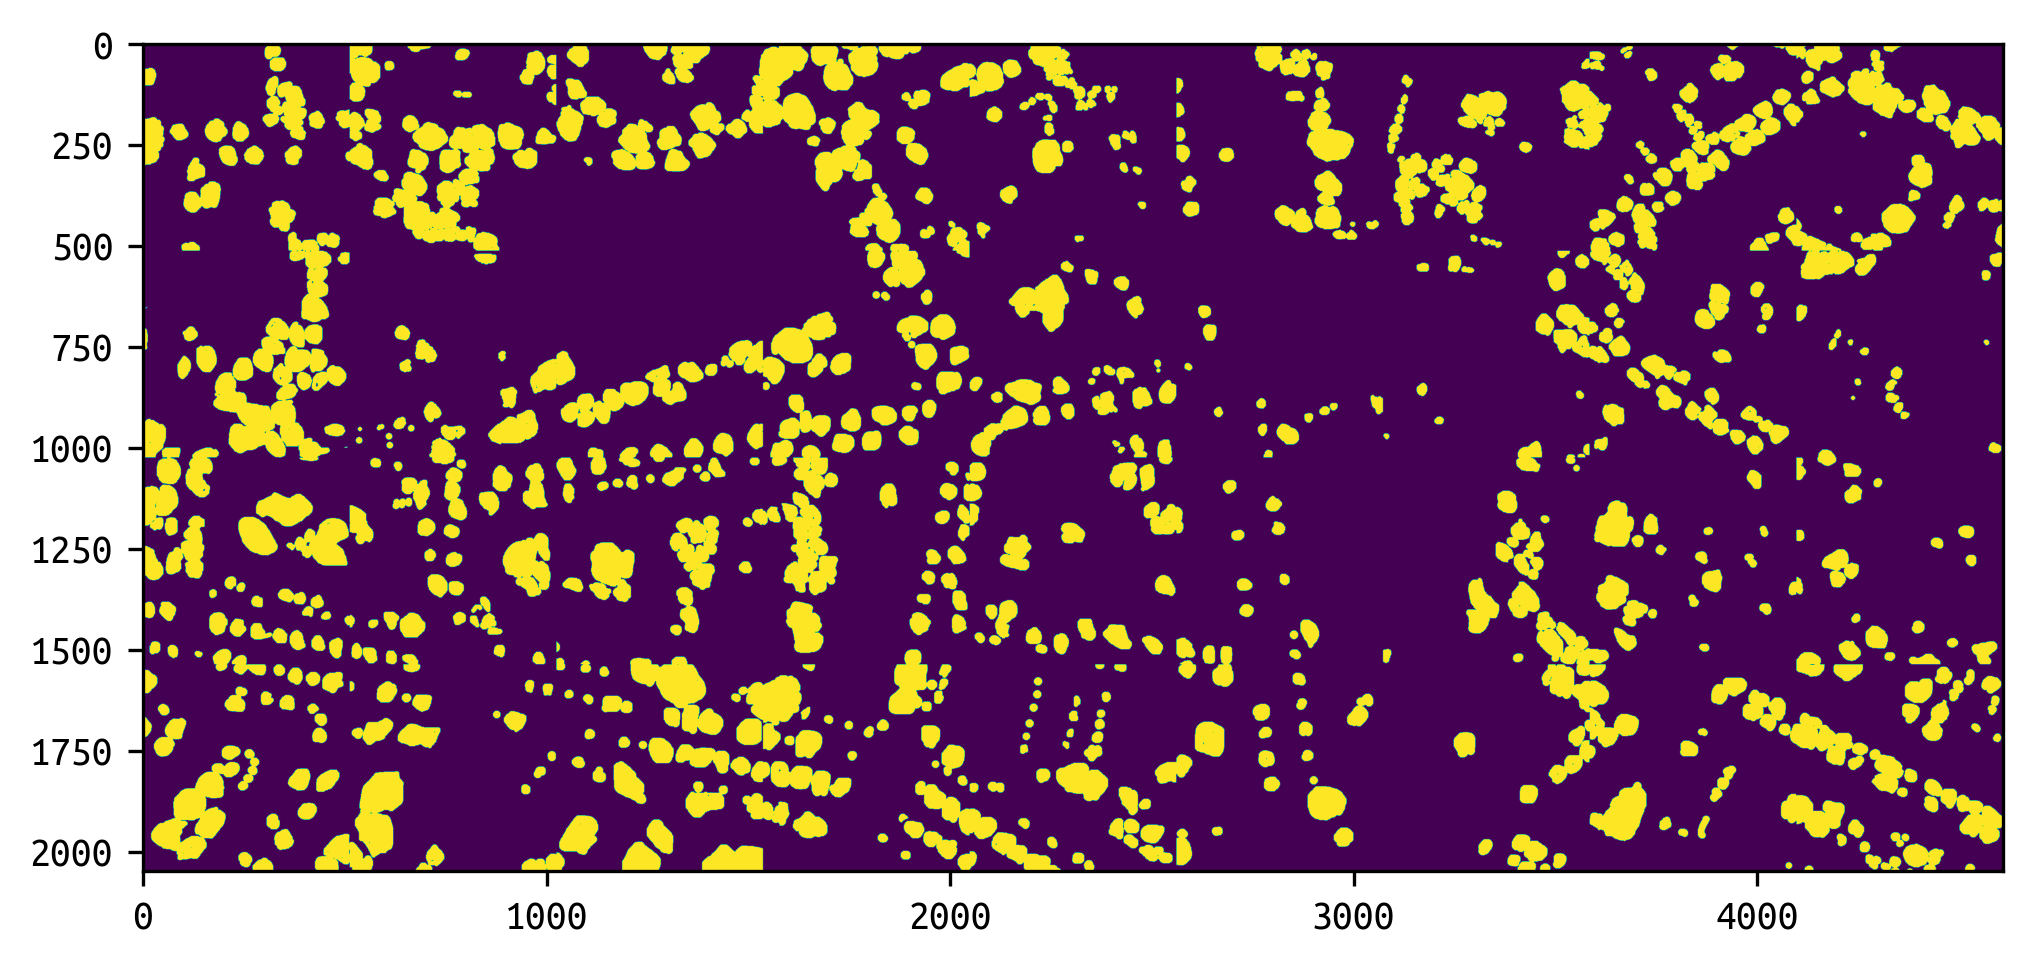

In [29]:
plt.imshow(tile_true)

In [45]:
i = 0
j = 0

5


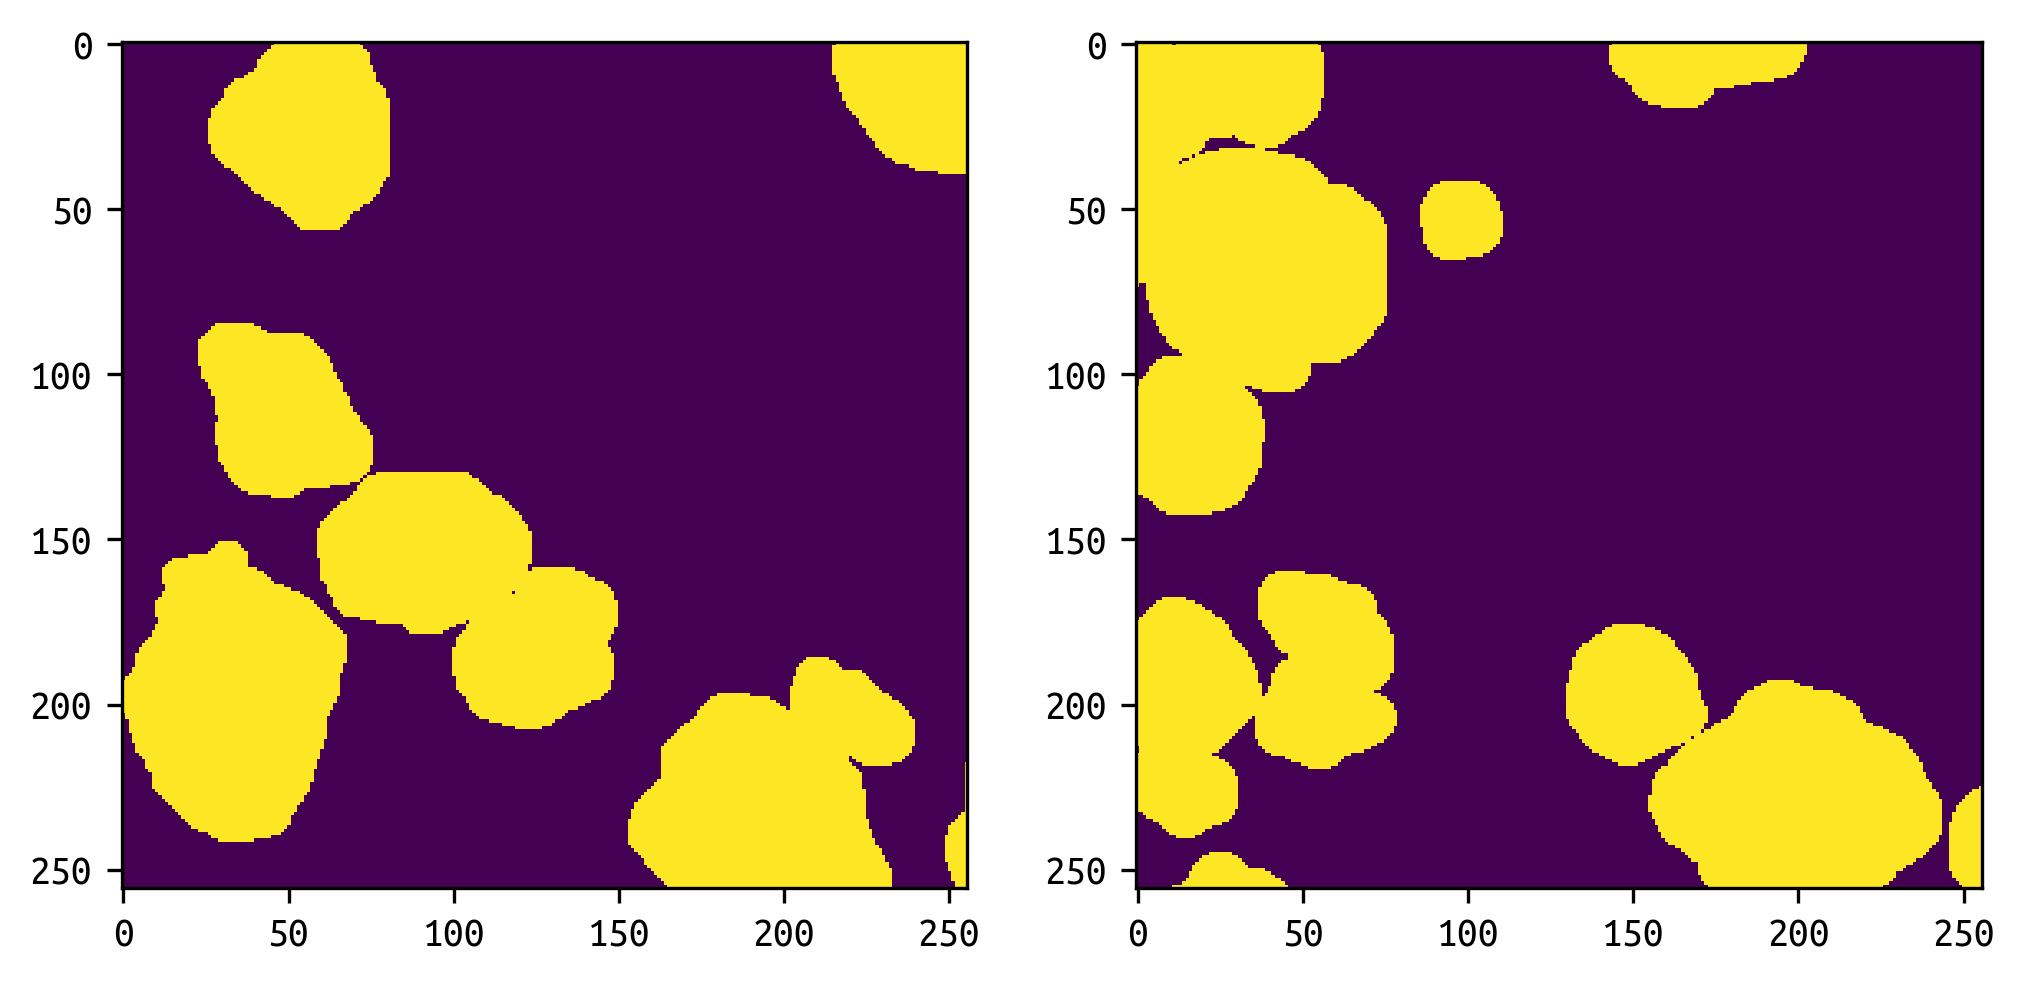

In [52]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(tile_true[256*j:256*(j+1), 256*i:256*(i+1)])
ax[1].imshow(y[i, ..., 0])
i += 1
print(i)

In [21]:
model = tf.keras.models.load_model(
    model_fns[5],
    custom_objects={
        "tversky": config.loss,
        "dice_coef": config.metrics[0],
        "dice_loss": config.metrics[1],
        "accuracy": config.metrics[4],
        "specificity": config.metrics[2],
        "sensitivity": config.metrics[3],
    },
    compile=False,
)

# In case you want to use multiple GPU you can uncomment the following lines.
# from tensorflow.python.keras.utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=2, cpu_merge=False)

model.compile(
    optimizer=config.optimizer,
    loss=config.loss,
    metrics=config.metrics,
)

y_pred = model.predict(X, steps=1)

NameError: name 'X' is not defined